In [ ]:
# Due to current import difficulties, code repeated here

In [7]:
""" 
Module to calculate the fitness of the current generation
"""
from typing import List, Tuple
from numpy import ndarray
import numpy as np
from statsmodels.regression.linear_model import RegressionModel
import statsmodels.api as sm

class _CalculateFit:
    
    def __init__(self):
        pass
    
    def calc_fit_sort_population(self, 
        current_population: ndarray
    ) -> Tuple[ndarray, ndarray]:
        """
        Calculated fitness of organisms and sorts population based on fitness score (AIC). From low AIC (best) to high.
        
        Inputs: Current population
        Outputs: Sorted population, sorted fitness scores
        """
        
        fitness_scores: ndarray = self.calculate_fit_of_population(current_population)
        return self.sort_population(current_population, fitness_scores)
    
    def sort_population(self, 
        current_population: ndarray, fitness_scores
        )-> Tuple[ndarray, ndarray]:
        """
        Sorts population based on fitness score (AIC). From low AIC (best) to high.
        
        Inputs: Current population, Fitness scores per organism
        Outputs: Sorted population, sorted fitness scores
        """
        
        sort_index = np.argsort(fitness_scores)
        
        return current_population[sort_index], fitness_scores[sort_index]
    
    
    def calculate_fit_of_population(self, 
        current_population: ndarray
        ) -> ndarray:
        """
        Calculates fitness of all organism in generation.
        
        Inputs: Current population
        Outputs: Fitness score per organism
        """
        fitness_scores = []
        for organism in current_population:
            X_trimmed = self.select_features(organism)
            fitness_scores.append(self.calculate_fit_per_organism(X_trimmed))
        return np.array(fitness_scores)
            
    def calculate_fit_per_organism(self, X_trimmed: ndarray) -> float:
        """
        Calculates fitness of one organism based on trimmed data according to its allels.
        
        Inputs: Trimmed data
        Outputs: Fitness score of organism
        """
        X_trimmed_w_intercept = sm.add_constant(X_trimmed)
        mod = self.mod(self.y, X_trimmed_w_intercept)

        # Check if the model is an instance of RegressionModel
        if not isinstance(mod, RegressionModel):
            raise TypeError(f"The model must be an instance of a statsmodels linear regression model. Instead it is {type(mod)}")
        
        #print(mod.fit().params)

        aic = mod.fit().aic
        return aic
        
    def select_features(self, organism: ndarray) -> ndarray:
        """
        Drops non-relevant features from data based on allels of an organism.
        
        Inputs: Single organism - Size: (1 x C (number of predictors))
        Outputs: Data to be used for fitness calculation of this organism
        """
      
        X_trimmed = self.X.drop(columns=self.X.columns[organism == 0], axis=1)
        #X_trimmed = self.X[:, organism != 0]

        return X_trimmed

In [8]:
""" 
Module to perform crossover (genetic operator) to the current generation
"""
import numpy as np
from numpy import ndarray

class _CrossOver:
    
    def __init__(self):
        pass
    
    def split_and_glue_population(self, current_population: ndarray) -> ndarray:
        """
        Performs split-and-glue crossover to current population (assuming 1&2 is paired, 3&4, etc.)
       
        Inputs: Current population
        Outputs: Population of children (pairwise cross-over)
        """
        count = 0
        new_population = np.zeros(current_population.shape).astype(int)
        for pair in np.arange(int(current_population.shape[0]/2)):
            new_population[count], new_population[count+1] = self.split_and_glue(current_population[count], current_population[count+1])
            count += 2
        return new_population

    
    def split_and_glue(self, parent1, parent2):
        """
        Crossover two parents to create two children. 
        The method used here is a simple split and glue approach. 
        The split position is randomly created.
        
        Inputs: Two parent organisms
        Outputs: Two child organisms (crossed-over)
        """
        cut_idx = np.random.randint(0, len(parent1))
        child1 = np.concatenate((parent1[0:cut_idx], parent2[cut_idx:]))
        child2 = np.concatenate((parent2[0:cut_idx], parent1[cut_idx:]))
        return child1, child2
    
    
    def random_allel_selection_population(self, current_population: ndarray) -> ndarray:
        """
        Performs random allel selection crossover to current population (assuming 1&2 is paired, 3&4, etc.)
       
        Inputs: Current population
        Outputs: Population of children (pairwise cross-over)
        """
        count = 0
        new_population = np.zeros(current_population.shape)
        for pair in np.arange(int(current_population.shape[0]/2)):
            new_population[count], new_population[count+1] = self.random_allel_selection(current_population[count], current_population[count+1])
            count += 2
        return new_population
    
    def random_allel_selection(self, parent1, parent2):
        """
        Crossover two parents to create two children. 
        The method randomly selects an allel from one of the parents per loci.
        
        Inputs: Two parent organisms
        Outputs: Two child organisms (crossed-over)
        """
        rng = np.random.default_rng()
        
        allel_selector = rng.binomial(1, 0.5, size = parent1.shape[0])
        allel_selector_reversed = 1-allel_selector
        
        child1 = allel_selector*parent1 + allel_selector_reversed*parent2
        child2 = allel_selector*parent2 + allel_selector_reversed*parent1
        return child1, child2

In [9]:
""" 
Mutation module with genetic operator "mutation"
"""

import numpy as np
from numpy import ndarray
class _Mutation:
    
    def __init__(self):
        pass

    def random_mutate(self, current_population: ndarray) -> ndarray:
    
        """
        Randomly switches genes (bit switch) in generation with probability mutate_prob

        Inputs: Generation of organisms - Size: (pop_size x C (number of predictors))
        Outputs: Generation of mutated organisms of same size
        
        """

        # initialize random generator
        rng = np.random.default_rng()
        
        population_new = current_population.copy()
        mutation_locations = rng.binomial(1, self.mutate_prob, size=current_population.shape)
        mask = mutation_locations == 1
        population_new[mask] = 1 - population_new[mask]  # flip bits using the mask
        return population_new


In [10]:
class _ParentSelection:

    def __init__():
        pass

    def calculate_phi(self, current_population):
        """
        Calculate selection probability as 2r_i/P(P+1)
        """
        P = self.pop_size    # Best ranked is P, then P-1, P-2,...,1
        rs = np.arange(P, 0, -1)
        phi = 2 * rs/(P*(P+1))

        return phi

    def select_from_fitness_rank(self, current_population):
        """
        Choose parents based on fitness ranks
        """
        selection_prob = self.calculate_phi(current_population)
                
        row_idx = np.arange(len(current_population))
        chosen_rows = np.random.choice(row_idx, size=self.pop_size, p=selection_prob,replace=True)
        chosen_individuals = current_population[chosen_rows]

        return chosen_individuals

In [35]:
import random
from functools import partial
from typing import Callable, List
import statsmodels.api

import numpy as np
from numpy import ndarray

#from .utils import _CalculateFit, _CrossOver, _Mutation, _ParentSelection

class GA (_CalculateFit,
          _ParentSelection,
          _CrossOver,
          _Mutation
         ):
    def __init__(
        self, 
        X: ndarray,
        y: ndarray,
        mod: Callable,
        max_iter: int,
        pop_size: int = None,  # type: ignore
        # fitness_func = "AIC",
        starting_population: ndarray = None,  # type: ignore
        mutate_prob: float = 0.01,
        save_sols: bool = False,
        random_seed: int = None,  # type: ignore
        ):
        """
        parameters:
        --------
            X: design matrix (assuming no intercept column)
            y: outcome variable
            mod: regression model (statsmodels)
            max_iter: GA max iteration
            pop_size: GA population size
            starting_population: if set use it as initial GA population
            mutate_prob: GA mutation probability
            save_sols: ... TODO
            random_seed: random seed value

        examples:
        --------
   ...: from GA import *
   ...: import statsmodels.api as sm
   ...: import numpy as np
   ...: 
   ...: spector_data = sm.datasets.spector.load()
   ...: 
   ...: X = spector_data.exog
   ...: y = spector_data.endog
   ...: 
   ...: # Initialize GA class
   ...: ga_1 = GA(X=X, y=y, mod=sm.OLS, max_iter=10, random_seed=1)
   ...: 
   ...: # Run GA under default operators
   ...: final_pop, fit = ga_1.select()
   ...: print(final_pop, fit)

   ...: # Specify own operator, population size, and mutation probability
   ...: operator = [GA.random_mutate, GA.random_mutate, GA.split_and_glue_population]
   ...: ga_2 = GA(X=X, y=y, mod=sm.OLS, max_iter=10, pop_size = 4, mutate_prob=0.01, random_seed=12) TODO
   ...: final_pop, fit = ga_2.select(operator)
   ...: print(final_pop, fit)   
        """
        self.random_seed: int = random_seed
        if random_seed:
            np.random.seed(self.random_seed)
            random.seed(self.random_seed)

        self.C: int = X.shape[1]    # this is ASSUMING NO intercept column

        if pop_size is None:
            self.pop_size: int = int(1.5 * self.C)    # C < P < 2C
        else:
            self.pop_size: int = pop_size

        self.X: ndarray = X
        self.y: ndarray = y
        self.mod: Callable = mod
        self.max_iter: int = max_iter
        self.mutate_prob: float = mutate_prob
        # self.fitness_func = fitness_func
        self.starting_population: ndarray = starting_population
        self.current_population = None

        if save_sols == True:
            self.solutions_matrix = np.zeros((self.max_iter, self.C))    # Pre-specify matrix for storing solutions
        else:
            pass

    def initialize_pop(self):
        """
        Creates the starting population
        returns:
            starting_population: ndarray (random bool matrix used to sample self.X)
        """
        if not isinstance(self.starting_population, ndarray):    # Specify a starting pop
            if self.pop_size % 2 == 1:    # If pop_size is odd
                self.pop_size = self.pop_size + 1    # Only allow even number for population size
                print(f"Original pop_size is odd - new pop_size: {self.pop_size}")
            
            cols = self.C
            self.starting_population = np.random.choice([0, 1], size=(self.pop_size, cols))    # Complete random generation
            
        else:
            pass
            
        self.starting_population = self.replace_zero_chromosome(self.starting_population)    # Replace chromosome of all zeros
        
        return self.starting_population

    def select(self, operator_list: List[Callable] = None):
        """
        Runs variable selection based on a user-defined genetic operator sequence: operator_list            
        """
        """Set random seed"""
        random.seed(self.random_seed)

        # set default mutation methods
        # assigns user specified operator_list if its not None
        operator_list = operator_list or [
            self.split_and_glue_population,
            self.random_mutate,
            ]       
        #for i, f in enumerate(operator_list):
        #    if f.__name__ == "random_mutate":
        #        operator_list[i] = partial(f, mutate_prob=self.mutate_prob)
        print(f"Using genetic operators: {operator_list}.")

        """Prepare GA"""
        starting_pop = self.initialize_pop()
        current_pop = starting_pop.copy()

        for i in range(self.max_iter):
            """Calculates fitness and pairs parents"""
            # chrom_ranked: ordered bool matrix(current_pop) from the fittest to unfittest
            chrom_ranked, fitness_val = self.calc_fit_sort_population(current_pop)
            parents = self.select_from_fitness_rank(chrom_ranked)
            current_pop = parents    # update current_pop's chromosome
            print(f"[iteration {i+1}] score: {fitness_val[0]:3.4f} | {chrom_ranked[0]}")

            # Runs genetic operator sequence
            for method in operator_list:
                new_population = method(current_pop)
                current_pop = new_population
            
            # Check if any chromosome of zeros and replace the row
            current_pop = self.replace_zero_chromosome(current_pop)    
        
        final_pop = current_pop.copy()
        self.final_pop_sorted, self.final_fitness_val = self.calc_fit_sort_population(final_pop)
        
        return (self.final_pop_sorted[0], self.final_fitness_val[0])
    
    def replace_zero_chromosome(self, population):
        """
        Finds if any chromosome is all zeros, and replaces the zero rows with random 0,1s
        """
        while np.any((population == 0).all(axis=1)):
            # Find the indices of rows with all zeros
            zero_rows_indices = np.where((population == 0).all(axis=1))[0]

            # Replace each zero row with a randomly generated 0,1 row
            for row_index in zero_rows_indices:
                population[row_index] = np.random.randint(0, 2, self.C)
        
        return population
            



In [36]:
import pandas as pd 
import statsmodels.api as sm

data = pd.read_csv("./assets/baseball.dat", delimiter = ' ')

X = data.drop("salary", axis = 1)
y = data["salary"]

In [37]:
GA = GA(pop_size=26, X=X, y=y, mod=sm.OLS, max_iter=100)

In [15]:
GA.select()

Using genetic operators: [<bound method _CrossOver.split_and_glue_population of <__main__.GA object at 0x7f7837915c90>>, <bound method _Mutation.random_mutate of <__main__.GA object at 0x7f7837915c90>>].
[iteration 1] score: 5384.8545 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1]
[iteration 2] score: 5384.8545 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1]
[iteration 3] score: 5384.3443 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0]
[iteration 4] score: 5381.8133 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]
[iteration 5] score: 5380.0512 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1]
[iteration 6] score: 5380.0512 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1]
[iteration 7] score: 5380.0512 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1]
[iteration 8] score: 5379.9741 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0]
[iteration 9] score: 5378.8751 | [0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 

[iteration 90] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 91] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 92] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 93] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 94] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 95] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 96] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 97] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 98] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 99] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]
[iteration 100] score: 5373.8498 | [0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0]


(array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0]),
 5373.8497566549095)

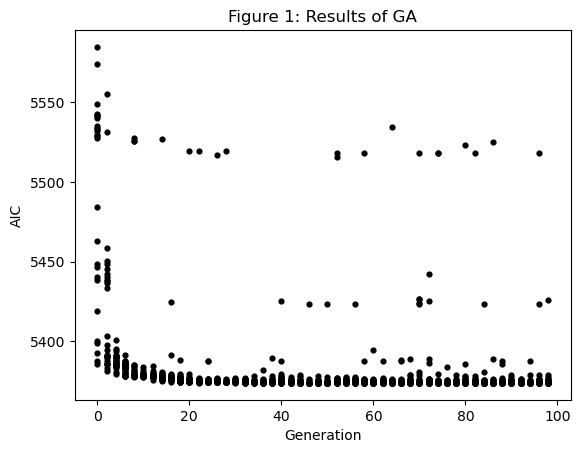

In [44]:
import matplotlib.pyplot as plt

starting_pop = GA.initialize_pop()
current_pop = starting_pop.copy()
operator_list = [GA.split_and_glue_population, GA.random_mutate]

for i in range(GA.max_iter):
    # Calculates fitness and pairs parents
    chrom_ranked, fitness_val = GA.calc_fit_sort_population(current_pop)
    parents = GA.select_from_fitness_rank(chrom_ranked)
    current_pop = parents
    if i%2 == 0:
        plt.scatter([i]*len(fitness_val), fitness_val, color = "black", s=12)

    # Runs genetic operator sequence
    for method in operator_list:
        new_population = method(current_pop)
        current_pop = new_population
    # Check if any chromosome of zeros and replace the row
    current_pop = GA.replace_zero_chromosome(current_pop)    

plt.ylabel("AIC")
plt.xlabel("Generation")
plt.title("Figure 1: Results of GA")
#plt.savefig("GA_results_plot_baseball.png")

final_pop = current_pop.copy()
GA.final_pop_sorted, GA.final_fitness_val = GA.calc_fit_sort_population(final_pop)

fittest_org, fittest_score = (GA.final_pop_sorted[0], GA.final_fitness_val[0])

In [46]:
fittest_org, fittest_score

(array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0]),
 5373.74894828915)

## Fit Lasso

In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = sm.add_constant(X_scaled)

In [115]:
Lasso = sm.OLS(y, X).fit_regularized(method = "elastic_net", alpha = 0.1, L1_wt = 1)
lasso_params= Lasso.params.sort_values()

<BarContainer object of 27 artists>

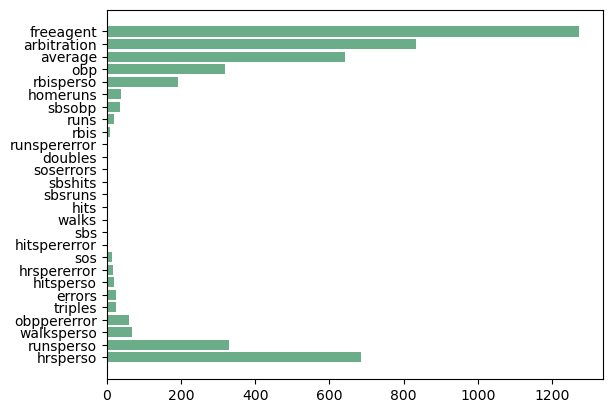

In [116]:
import matplotlib.pyplot as plt
import numpy as np
plt.barh(lasso_params.index, np.abs(lasso_params.values), label = "Lasso", color = "seagreen", align = "center", alpha = 0.7)

## Fit fittest organism

In [76]:
X_trimmed = X.drop(X.columns[fittest_org == 0], axis=1)

In [77]:
Regression_GA = sm.OLS(y, X_trimmed).fit()
reg_params = pd.Series(index = lasso_params.index).fillna(0)
reg_params[Regression_GA.params.index] = Regression_GA.params.values

/var/folders/9v/21xqllks32b9v9gj8tm8bf4m0000gn/T/ipykernel_48975/2490332900.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  reg_params = pd.Series(index = lasso_params.index).fillna(0)


## Plot

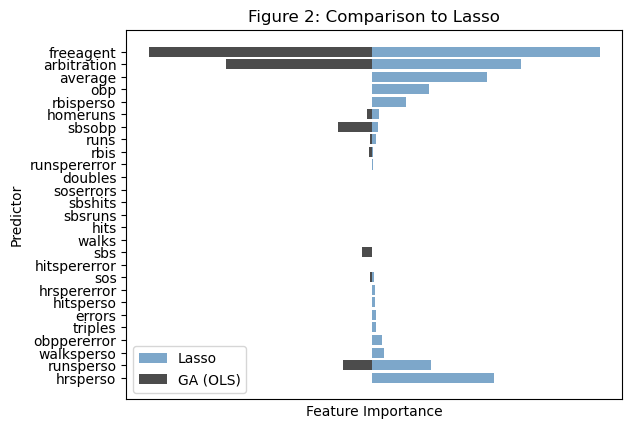

In [84]:
plt.barh(lasso_params.index, np.abs(lasso_params.values), label = "Lasso", color = "steelblue", align = "center", alpha = 0.7)
plt.barh(lasso_params.index, -np.abs(reg_params.values), label = "GA (OLS)", color = "black", align = "center", alpha = 0.7)
plt.xlabel("Feature Importance")
plt.ylabel("Predictor")
plt.title("Figure 2: Comparison to Lasso")
plt.legend()
plt.xticks([])
plt.savefig("LASSO_comparison.png")

In [67]:
X.columns

Index(['average', 'obp', 'runs', 'hits', 'doubles', 'triples', 'homeruns',
       'rbis', 'walks', 'sos', 'sbs', 'errors', 'freeagent', 'arbitration',
       'runsperso', 'hitsperso', 'hrsperso', 'rbisperso', 'walksperso',
       'obppererror', 'runspererror', 'hitspererror', 'hrspererror',
       'soserrors', 'sbsobp', 'sbsruns', 'sbshits'],
      dtype='object')

In [73]:
Regression_GA2 = sm.OLS(y, X_trimmed).fit()
Regression_GA2.params

runs              8.102434
homeruns         25.742733
rbis             15.038548
sos              -9.837904
sbs             -54.356513
freeagent      1245.251684
arbitration     813.314139
runsperso      -159.714962
soserrors        -0.125224
sbsobp          191.485220
dtype: float64

In [90]:
(fittest_org==0).sum()

17

In [95]:
(np.abs(Lasso.params) <= 0.01).sum()

0

In [109]:
(np.abs(Lasso.params.values) <= 20).sum()

13

In [102]:
np.abs(Lasso.params.values) < 1

array([False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True])

In [105]:
Lasso.params.values.astype(float)

array([ 6.41879294e+02,  3.18731601e+02,  2.07404910e+01, -5.82230765e-01,
        2.99714613e+00, -2.61453043e+01,  3.93182855e+01,  7.81501742e+00,
       -7.74784496e-01, -1.37957590e+01, -1.24865677e+00, -2.59617877e+01,
        1.27296742e+03,  8.34211441e+02, -3.29074760e+02, -1.98022705e+01,
       -6.85109419e+02,  1.93158773e+02, -6.79571886e+01, -5.92997154e+01,
        3.99739872e+00, -3.61285767e+00, -1.80701868e+01,  5.82149264e-02,
        3.46885615e+01, -1.18492392e-01,  4.92365282e-02])